# <font style="color: rgb(0,0,0);">Option B: </font> <font style="color: rgb(190,138,67);">Transport efficiency</font>

## modelling the Launch Segment

imitating ascent characteristics from Apollo return flights

> Apollo 11 https://www.hq.nasa.gov/alsj/nasa58040.pdf
<br>
> Apollo 17 https://history.nasa.gov/alsj/a17/A17_MissionReport.pdf

Segmented flight: vertical rise, orbit injection

In [3]:
# imports
import numpy as np
import pandas as pd
pd.set_option('display.expand_frame_repr', False)
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import matplotlib.gridspec as gridspec
from io import StringIO
from csv import writer 
from scipy import integrate
import math
import numba
from numba import jit
import time as time_lib
from tqdm import tqdm
import xarray as xr
from multiprocessing import Pool

def current_milli_time():
    return round(time_lib.time() * 1000 *1000)

In [16]:
import subprocess

Longitude = [-90,0,90]
Latitude  = [60,-60]
Start_Height = [1,1,1,2,2,2]

args = [Longitude,Latitude,Start_Height]

result = subprocess.check_output("B_Launch_Segment_solver.py" + " " + str(args).replace(" ", ""), shell=True)
print(result.decode("utf-8"))

Argument: [[-90, 0, 90], [60, -60], [1, 1, 1, 2, 2, 2]]
[1, 1, 1, 2, 2, 2]
Done.



In [15]:
# load result array
with xr.open_dataarray("maps/Launch_Segement.nc") as ds:
    xA_result = ds.load()

xA_result

<xarray.DataArray (lat: 2, lon: 3)>
array([[1., 1., 1.],
       [4., 4., 4.]])
Coordinates:
  * lon      (lon) int16 -90 0 90
  * lat      (lat) int16 60 -60
Attributes:
    description:  DeltaV to Gateway
    var_desc:     deltaV
    units:        m/s

In [6]:
# constants

r_moon = 1737400    # [m] volumetric mean radius of the moon
m_moon = 0.07346e24 # [kg] mass of the moon
G = 6.67430e-11 # Gravitational constant



# acceleration direction from propulsion
#         0°
#         │                
# 270° ───┼─── 90°     reference angle from vertical axis, perpendicular to lunar surface
#         │
#        180°


def angle(vec,v_ref=None,rad=False):
    
    if v_ref is not None:
        vector_1 = v_ref
    else:
        vector_1 = [0, 1, 0]
    vector_2 = vec
    
    if np.linalg.norm(vector_2) == 0: return None

    unit_vector_1 = vector_1 / np.linalg.norm(vector_1)
    unit_vector_2 = vector_2 / np.linalg.norm(vector_2)
    dot_product = np.dot(unit_vector_1, unit_vector_2)
    angle = np.arccos(dot_product)
    
    if vec[0]<0:
        angle = 2*np.pi - angle
    
    #print(np.rad2deg(angle))
    
    if rad: return angle
    return np.rad2deg(angle)
    

def vec_from_angle(deg): # in [x,y] cartesian-coordinates
    rad = np.deg2rad(90-deg)

    y = np.sin(rad)
    x = np.cos(rad)
    vec = np.array([x,y,0], dtype=np.float64)
    
    
    # verify
    #print(f'vector angle is {angle(vec)}°')
    
    return vec

def dir_from_angle(deg): # in [x,y] cartesian-coordinates
    if deg >= 0:
        rad = np.deg2rad(90-deg)
    if deg < 0:
        rad = - np.deg2rad(90-abs(deg))

    y = np.sin(rad)
    x = np.cos(rad)
    vec = np.array([x,y,0], dtype=np.float64)
    
    
    # verify
    #print(f'vector angle is {angle(vec)}°')
    
    return vec

def plot_vector(vec):
    
    plt.figure(figsize=(3, 3), dpi=50)
    
    # reference vector
    xpoints = np.array([0, 0])
    ypoints = np.array([0, 1])
    plt.plot(xpoints, ypoints, '--', color = 'b')
    
     
    xpoints = np.array([0, vec[0]])
    ypoints = np.array([0, vec[1]])
        
    plt.plot(xpoints, ypoints, color = 'r')
    
    plt.ylim(-1.1, 1.1)
    plt.xlim(-1.1, 1.1)
    
    plt.gca().set_aspect('equal', adjustable='box')
    
    #unit circle
    t = np.linspace(0,np.pi*2,100)
    plt.plot(np.cos(t), np.sin(t), linewidth=2)
    
    plt.axis('off')
    plt.show()

#def norm(vec):
#    # r = length of pos vector
#    return np.linalg.norm(vec)


def r_sys(vec, pos):

    alpha = angle(pos,rad=True)
    #print(alpha)

    rot = np.array([[np.cos(alpha), -np.sin(alpha)], [np.sin(alpha), np.cos(alpha)]])
    #print(rot)

    v = np.array([vec[0], vec[1]], dtype=np.float64)

    v2 = np.dot(rot, v)
    
    r_vec = np.array([v2[0], v2[1], vec[2]], dtype=np.float64)
    #print(vec,r_vec)
    
    return r_vec

# verify
test_pos = np.array([1.0, 1.0 , 0.0]) # angle
test_xy = np.array([0.5, 0.5 , 0])
test_r = r_sys(test_xy,test_pos)
print('test r_sys(vec,pos) function:','at test_pos',test_pos,'angle',angle(test_pos),'transform test_xy',test_xy,'in test_r',test_r)
print('from:',test_xy)
print('to:',test_r)

def xy_sys(vec, pos):

    alpha = -angle(pos,rad=True) 
    #print(alpha)

    rot_xy = np.array([[np.cos(alpha), -np.sin(alpha)], [np.sin(alpha), np.cos(alpha)]])
    #print(rot)

    v = np.array([vec[0], vec[1]], dtype=np.float64)

    v2 = np.dot(rot_xy, v)
    
    xy_vec = np.array([v2[0], v2[1], vec[2]], dtype=np.float64)
    #print(vec,r_vec)
    
    return xy_vec

# verify
test2_pos = np.array([1.0, 1.0 , 0.0])
test2_r = np.array([-5.55111512e-17 , 7.07106781e-01 , 0.00000000e+00])
test2_xy = xy_sys(test2_r,test2_pos)
print('test xy_sys(vec,pos) function:','at test_pos',test2_pos,'angle',angle(test2_pos),'transform test_xy',test2_xy,'in test_r',test2_r)
print('from:',test2_r)
print('to:',test2_xy)

def altitude(pos):
    r = np.linalg.norm(pos)
    return r - r_moon

def deltaV(mass_fuel_used,mass_full,EEV):
    # compute deltaV from used mass of fuel
    dV = EEV * np.log(mass_full / (mass_full-mass_fuel_used))
    
    return dV

def downrange_distance(pos):
    # known starting point at [ x = 0, y = r_moon ]
    alpha = angle(pos)
    # circular arc = alpha * r
    dist = alpha * r_moon
    return dist

@jit(nopython=True)
def orbital_velocity(altitude):
    return np.sqrt((G * m_moon)/(r_moon + altitude))

@jit(nopython=True)
def acc_grav_moon(pos):
    r = np.linalg.norm(pos)
    r_val = G * (m_moon/(r**2))
    e_r = -(pos / r)
    
    return (e_r * r_val)

def acc_centrifugal(pos,vel,scalar=False):
    r = np.linalg.norm(pos)
    v = r_sys(vel,pos)[0] # vel portion that is ⊥ to r -> phi_val
    r_val = (v**2)/(r)
    if scalar: return r_val
    else:
        e_r = (pos / r)
        return (e_r * r_val)

print('test acc_grav_moon(r) function:',acc_grav_moon(np.array([0.0,r_moon,0.0])),'[m/s²]','vs. 1.622 [m/s²] expected on surface')

@jit(nopython=True)
def acc_propulsion(m,m_flow,EEV):
    F_thrust = m_flow * EEV
    acc = F_thrust / m

    return acc
    
print('test acc_propulsion(m) function:',acc_propulsion(8500,15,4000),'[m/s²]')

test r_sys(vec,pos) function: at test_pos [1. 1. 0.] angle 45.00000000000001 transform test_xy [0.5 0.5 0. ] in test_r [-5.55111512e-17  7.07106781e-01  0.00000000e+00]
from: [0.5 0.5 0. ]
to: [-5.55111512e-17  7.07106781e-01  0.00000000e+00]
test xy_sys(vec,pos) function: at test_pos [1. 1. 0.] angle 45.00000000000001 transform test_xy [0.5 0.5 0. ] in test_r [-5.55111512e-17  7.07106781e-01  0.00000000e+00]
from: [-5.55111512e-17  7.07106781e-01  0.00000000e+00]
to: [0.5 0.5 0. ]
test acc_grav_moon(r) function: [-0.         -1.62426548 -0.        ] [m/s²] vs. 1.622 [m/s²] expected on surface
test acc_propulsion(m) function: 7.0588235294117645 [m/s²]


In [7]:
class PID_Controller:
  def __init__(self, set_alt , t_step):
    
    # variables
    self.int_sum = 0
    self.e_old = None
    self.t_step = t_step
    self.set_alt = set_alt


  def step(self,pos):
    # calculate error

    e = self.set_alt - altitude(pos)
    
    # simple integration
    self.int_sum += e * self.t_step    
    

    if self.e_old is None:
        d_val = 0
    else:
        d_val = (e - self.e_old) / self.t_step
    
    self.e_old = e
    
    # Controller formular
    u =  2*e + 10 * d_val + 0.1 * self.int_sum
    
    # sigmoid for mapping
    try:
        exp = math.exp(-0.5 *u)
    except OverflowError:
        exp = float('inf')
    
    sigm = (2/(1 + exp) ) -1
    
    # +/-20° freedom
    alpha = -20 * sigm

    dir_n = dir_from_angle(90+alpha)
    
    # transform from r_sys to x_sys
    dir_n_xy = xy_sys(dir_n, pos)

    return dir_n_xy

In [8]:
@jit(nopython=True)
def phys_sim_step(time,t_step, pos, vel, acc, m, mass_dry, m_flow, EEV, dir_n, engine_on):
    
    # one sim step BEGIN
    # Velocity Verlet - numerical solution to differential equation
    ###############################
    new_pos = np.add( np.add(pos, vel*t_step) , acc*(t_step*t_step*0.5))
    new_acc = np.add( dir_n * acc_propulsion(m,m_flow,EEV), acc_grav_moon(pos))
    new_vel = np.add( vel , (np.add(acc,new_acc))*(t_step*0.5))
    
    if engine_on:
        new_mass = np.subtract(m , (m_flow * t_step))
        if new_mass < mass_dry:
            print('CRITICAL - FUEL EMPTY')
            new_mass = m
            engine_on = False
    else: new_mass = m
    
    new_time = np.around(time + t_step,3) # digit_precision = 3
    
    return new_time,new_pos,new_vel,new_acc,new_mass,engine_on ;

    ###############################
    # one sim step END
   
phys_sim_step(np.array(0, dtype=np.float64),np.array(0.01, dtype=np.float64),np.array([0,r_moon,0], dtype=np.float64),np.array([0,0,0], dtype=np.float64),np.array([0,0,0], dtype=np.float64),8500,1600, 15, 4000, vec_from_angle(0),True) # pysical sim step

(0.01,
 array([      0., 1737400.,       0.]),
 array([2.16114141e-18, 2.71727903e-02, 0.00000000e+00]),
 array([4.32228282e-16, 5.43455805e+00, 0.00000000e+00]),
 8499.85,
 True)

In [9]:
def write_data_row(csv_writer,time,pos,vel,acc,m,dir_n):
    csv_writer.writerow([time,m,altitude(pos),pos[0],pos[1],pos[2],r_sys(vel,pos)[1],r_sys(vel,pos)[0],vel[0],vel[1],vel[2],r_sys(acc,pos)[1],r_sys(acc,pos)[0],acc[0],acc[1],acc[2],angle(dir_n)])
    
def log(csv_writer,time,pos,vel,acc,m,dir_n):
    x = 1
    # logging results only every x seconds
    if (time*1000)%(x) == 0:
        write_data_row(csv_writer,time,pos,vel,acc,m,dir_n)

# SIMULATION
#@jit(nopython=False,forceobj=True)
def simulation(t_step,target_altitude,mass_dry,mass_full):

    # set launch carrier properties
    # EL3 - European Large Logistics Lander
    mass_fuel = mass_full - mass_dry # kg
    m_flow = 15 #6.8 # [kg/s] massflow
    I_sp = 400 # [s] specific impulse
    g_0 = 9.80665 # [kg/s²] standard gravity
    EEV = np.array(I_sp * g_0, dtype=np.float64) # [m/s] effective exhaust velocity

    # setup parameters
    t_step = np.array(t_step, dtype=np.float64) # [s] time for one simulation step
    #digit_precision = 3

    time = np.array(0, dtype=np.float64)

    # cartesian coordinates - 3D
    #         y   z
    #         │ /              
    #      ───┼─── x    [x,y,z]
    #       / Moon       
    # point of origin = moon center mass point


    # initialize
    # Spacecraft properties

    # mass
    m = mass_full  # [kg]

    # position
    pos = np.array([0,r_moon,0], dtype=np.float64) # [m]

    # velocity
    #add ground speed vel
    vel = np.array([0,0,0], dtype=np.float64) # [m/s]

    # acceleration
    acc = np.array([0,0,0], dtype=np.float64) # [m/s²]

    # engine toggle
    engine_on = True
    # engine acc direction
    dir_n = vec_from_angle(0)

    # pandas df for logging
    # to increase appending speed, rows are written into memory then read back in pandas df
    output = StringIO()
    csv_writer = writer(output)

    csv_writer.writerow(['time [s]','mass [kg]','altitude [m]','pos_x [m]','pos_y [m]','pos_z [m]','vel_r [m/s]','vel_phi [m/s]','vel_x [m/s]','vel_y [m/s]','vel_z [m/s]','acc_r [m/s²]','acc_phi [m/s²]','acc_x [m/s²]','acc_y [m/s²]','acc_z [m/s²]','dir_n [°]'])

    csv_writer.writerow([time,m,altitude(pos),pos[0],pos[1],pos[2],r_sys(vel,pos)[1],r_sys(vel,pos)[0],vel[0],vel[1],vel[2],r_sys(acc,pos)[1],r_sys(acc,pos)[0],acc[0],acc[1],acc[2],angle(dir_n)])
    #write_data_row(time,pos,vel,acc,m,dir_n) # inital values at index 0 at time 0


    # Simulation execution

    """
    print('''
    ┌───────────┬─────────────────────────────────┐
    │  Phase 1  │          Vertical rise          │
    └───────────┴─────────────────────────────────┘''')
    """
    dir_n = vec_from_angle(0)
    #plot_vector(dir_n)

    # stop condition: time
    # stop Apollo velocity: 50 [ft/s] = 15.24 [m/s]
    # stop Appolo height: ~250 [ft] = 76.2 [m]

    #while vel[1] < 15.24: 
    while time < 10: 

        
        time, pos, vel, acc, m, engine_on = phys_sim_step(time,t_step,pos,vel,acc,m,mass_dry, m_flow, EEV, dir_n,engine_on) # pysical sim step

        log(csv_writer,time,pos,vel,acc,m,dir_n) # log every x [ms]


    phase1_end = time
    """
    print(f'Phase 1 finished at {phase1_end} s, Apollo 10 [s]')
    print(f'> height {pos[1]-r_moon} m, Apollo 76.2 [m]')
    print(f'> vertical vel {vel[1]} m/s Apollo 15.24 [m/s]')

    print('''
    ┌───────────┬─────────────────────────────────┐
    │  Phase 2  │      first tilt, 38° burn       │
    └───────────┴─────────────────────────────────┘''')
    """
    dir_n = vec_from_angle(38)
    #plot_vector(dir_n)

    # stop condition: time
    time_now = time
    while time < time_now + 2: 

        time, pos, vel, acc, m, engine_on = phys_sim_step(time,t_step,pos,vel,acc,m,mass_dry, m_flow, EEV, dir_n,engine_on) # pysical sim step

        log(csv_writer,time,pos,vel,acc,m,dir_n) # log every x [ms]

    phase2_end = time 
    """
    print(f'Phase 2 finished at {phase2_end} s')

    print('''
    ┌───────────┬─────────────────────────────────┐
    │  Phase 3  │     second tilt, 52° burn       │
    └───────────┴─────────────────────────────────┘''')
    """
    dir_n = vec_from_angle(52)
    #plot_vector(dir_n)

    # stop condition: time
    time_now = time
    while time < time_now + 2: 

        time, pos, vel, acc, m, engine_on = phys_sim_step(time,t_step,pos,vel,acc,m,mass_dry, m_flow, EEV, dir_n,engine_on) # pysical sim step

        log(csv_writer,time,pos,vel,acc,m,dir_n) # log every x [ms]

    phase3_end = time
    """
    print(f'Phase 3 finished at {phase3_end} s')
    print(f'> fuel mass used until here {mass_full - m} kg')



    # Phase 4.0: Orbit injection - bring vel_r = 0
    print('''
    ┌───────────┬──────────────────────────────────┐
    │ Phase 4.0 │   80° burn, set target_altitude  │
    └───────────┴──────────────────────────────────┘''')
    """
    angle_r = 78
    dir_n = xy_sys(vec_from_angle(angle_r),pos)
    
    #print(f'from {angle(dir_n)}° xy_sys')

    # stop condition: setting target_altitude
    avg_acc_grav = 0.5 * ((G * (m_moon/((np.linalg.norm(pos))**2))) + (G * (m_moon/((r_moon + target_altitude)**2))))
    acc_cent = abs(acc_centrifugal(pos,vel,scalar=True))
    est_phase41_time = r_sys(vel,pos)[1] / (avg_acc_grav - acc_cent)
    estimated_alt_gain = 0.5 * r_sys(vel,pos)[1] * est_phase41_time

    while (altitude(pos) < (target_altitude - estimated_alt_gain)):

        dir_n = xy_sys(vec_from_angle(angle_r),pos)

        avg_acc_grav = 0.5 * ((G * (m_moon/((np.linalg.norm(pos))**2))) + (G * (m_moon/((r_moon + target_altitude)**2))))
        acc_cent = abs(acc_centrifugal(pos,vel,scalar=True))
        est_phase41_time = r_sys(vel,pos)[1] / (avg_acc_grav - acc_cent)
        estimated_alt_gain = 0.5 * r_sys(vel,pos)[1] * est_phase41_time

        time, pos, vel, acc, m, engine_on = phys_sim_step(time,t_step,pos,vel,acc,m,mass_dry, m_flow, EEV, dir_n,engine_on) # pysical sim step

        log(csv_writer,time,pos,vel,acc,m,dir_n) # log every x [ms]

    
    #print(f'to   {angle(dir_n)}° xy_sys')
    #plot_vector(dir_n)

    phase40_end = time 
    #print(f'Phase 4.0 finished at {phase40_end} s')

    alt = altitude(pos)
    """
    print(f'> fuel mass used until here {mass_full - m} kg')
    print(f'> Altitude {alt} m reached, {estimated_alt_gain} m  gain expected at 4.1 in {est_phase41_time}s')
    print(f'> Orbital velocity {orbital_velocity(alt)} m/s needed')


    # Phase 4.1: Orbit injection - bring vel_r = 0
    print('''
    ┌───────────┬────────────────────────────┐
    │ Phase 4.1 │   90° burn until vel_r = 0 │
    └───────────┴────────────────────────────┘''')
    """
    angle_r = 90
    dir_n = xy_sys(vec_from_angle(angle_r),pos)
    #print(f'from {angle(dir_n)}° xy_sys')

    # stopping condition: radial velocity (vel_r)

    while r_sys(vel,pos)[1] > 0: 

        dir_n = xy_sys(vec_from_angle(angle_r),pos)

        time, pos, vel, acc, m, engine_on = phys_sim_step(time,t_step,pos,vel,acc,m,mass_dry, m_flow, EEV, dir_n,engine_on) # pysical sim step

        log(csv_writer,time,pos,vel,acc,m,dir_n) # log every x [ms]


    #print(f'to   {angle(dir_n)}° xy_sys')
    #plot_vector(dir_n)

    phase41_end = time 
    #print(f'Phase 4.1 finished at {phase41_end} s')

    alt = altitude(pos)
    """
    print(f'> fuel mass used until here {mass_full - m} kg')
    print(f'> Estimation Error: {est_phase41_time-(phase41_end-phase40_end)} s')
    print(f'> Altitude {alt} m reached')
    print(f'> Orbital velocity {orbital_velocity(alt)} m/s needed')
    print(f'> current Orbital velocity {r_sys(vel,pos)[0]} m/s')



    # Phase 4: Orbit injection
    print('''
    ┌───────────┬─────────────────────────────────────────────┐
    │ Phase 4.3 │   orbit injection, constant altitude burn   │
    └───────────┴─────────────────────────────────────────────┘''')
    """
    # init Controller to hold current altitude
    PID = PID_Controller(altitude(pos), t_step)
    """
    print(f'> current Altitude {alt} m')
    print('''
    ┌────────────┐
    │ Controller │ holding altitude constant with PID-Regulator
    └────────────┘''')
    """

    # stopping condition: orbital velocity (vel_phi)
    while r_sys(vel,pos)[0] < orbital_velocity(alt):

        dir_n = PID.step(pos)
        
        time, pos, vel, acc, m, engine_on = phys_sim_step(time,t_step,pos,vel,acc,m,mass_dry, m_flow, EEV, dir_n,engine_on) # pysical sim step
        
        if not engine_on: break

        alt = altitude(pos)

        log(csv_writer,time,pos,vel,acc,m,dir_n) # log every x [ms]

    phase4_end = time
    """
    print(f'Phase 4 finished at {phase4_end} s')
    print(f'> fuel mass used until here {mass_full - m} kg')
    print(f'> Orbital velocity {r_sys(vel,pos)[0]} m/s reached, where {orbital_velocity(alt)} m/s is needed for altitude {alt}')
    print(f'> pos {pos} m reached')
    print(f'> current Orbital velocity {r_sys(vel,pos)[0]} m/s')
    print(f'> Altitude {alt} m reached')
    """

    fuel_used = mass_full - m

    
    result_table = f'''
    ┌───────────────────────────────────────────────────────────┐
    │                        RESULT TABLE                       │
    ├───────────────────────────────────────────────────────────┤
    │ time           {time:8.3f} [s]      Apollo:    438     [s]   │
    │ used Fuel      {fuel_used:8.3f} [kg]     Apollo:   2238     [kg]  │
    │ delta V        {deltaV(fuel_used,mass_full,EEV):8.3f} [m/s]    Apollo:   1847     [m/s] │
    │ downrange dist {(downrange_distance(pos)/1000):8.3f} [km]     Apollo:    268.76  [km]  │
    │ altitude       {altitude(pos):8.3f} [m]      Apollo:  18288     [m]   │
    │ phi velocity   {r_sys(vel,pos)[0]:8.3f} [m/s]    Apollo:  16866.6   [m/s] │
    │ r velocity     {r_sys(vel,pos)[1]:8.3f} [m/s]    Apollo:      9.815 [m/s] │
    └───────────────────────────────────────────────────────────┘
    '''
    result_table = fuel_used

    """
    print('''
    ┌───────────┬─────────────────────────────────┐
    │  Phase 5  │   orbit propagate, engine off   │
    └───────────┴─────────────────────────────────┘''')

    dir_n =  np.array([0,0,0], dtype=np.float64)
    #plot_vector(dir_n)
    engine_on = False

    now_time = time

    while time < now_time + 400:

        phys_sim_step()

        log(1000) # log every full x [ms]

    
    
    print('''
    ├───────────────── FINISHED ──────────────────┤
    ''')
    """


    # load pandas df back from memory
    output.seek(0) # we need to get back to the start of the StringIO
    df = pd.read_csv(output)
    df = df.set_index('time [s]')
    
    return result_table, df


In [10]:
start_time = current_milli_time()
print('Checkpoint',(current_milli_time() - start_time) / 1000, '[ms]')
result_table, df = simulation(t_step=0.1,
                               target_altitude=2000,
                               mass_dry=1600,
                               mass_full=8500)

end_time = current_milli_time()
duration = (end_time - start_time) / 1000
print(duration,'[ms]')

print(result_table)
print(df)

Checkpoint 0.0 [ms]
1726.035 [ms]
3085.5
          mass [kg]  altitude [m]     pos_x [m]     pos_y [m]  pos_z [m]  vel_r [m/s]  vel_phi [m/s]   vel_x [m/s]  vel_y [m/s]  vel_z [m/s]  acc_r [m/s²]  acc_phi [m/s²]  acc_x [m/s²]  acc_y [m/s²]  acc_z [m/s²]  dir_n [°]
time [s]                                                                                                                                                                                                                       
0.0          8500.0      0.000000  0.000000e+00  1.737400e+06        0.0     0.000000   0.000000e+00  0.000000e+00     0.000000          0.0      0.000000    0.000000e+00  0.000000e+00      0.000000           0.0   0.000000
0.1          8498.5      0.000000  0.000000e+00  1.737400e+06        0.0     0.264904   2.119356e-17  2.119356e-17     0.264904          0.0      5.298076    4.238711e-16  4.238711e-16      5.298076           0.0   0.000000
0.2          8497.0      0.052981  4.238711e-18  1.737400e+06  

In [11]:
####################################################################################
# WARNING !    this step takes approx. x hours to compute for 5 deg resolution     #
####################################################################################

# calculation steps in deg for geodetic location
resolution = 90

print('Result image resolution:',1+(360/resolution),'x',1+(180/resolution))
n_total = (1+(360/resolution))*(1+(180/resolution))
print('number of calculations:',n_total)

if n_total != int(n_total): print("WARNING: non matching map!")

Longitude = []
Latitude = []

for Lon in range(-180,181,resolution):
    Longitude.append(Lon)
for Lat in range(-90,91,resolution):
    Latitude.append(Lat)


Latitude = list(reversed(Latitude))

data_used_fuel = np.zeros((len(Latitude), len(Longitude)))
data_used_fuel[:] = np.nan

storage_result_table = np.zeros((len(Latitude), len(Longitude)))
storage_result_table[:] = np.nan

print()
print(len(Longitude),Longitude)
print()
print(len(Latitude),Latitude)

with tqdm(total=n_total) as pbar:
    for Lat_count, Lat in enumerate(Latitude):
        for Lon_count, Lon in enumerate(Longitude):
            #print("Lat:",Lat,"Lon:",Lon)
            used_fuel, df = simulation(t_step=0.1,
                               target_altitude=2000,
                               mass_dry=1600,
                               mass_full=8500)
            
            #storage_df[Lat_count][Lon_count] = df
            data_used_fuel[Lat_count][Lon_count] = used_fuel
                
            pbar.update(1)

Result image resolution: 5.0 x 3.0
number of calculations: 15.0

5 [-180, -90, 0, 90, 180]

3 [90, 0, -90]


100%|████████████████████████████████████████████████████████████████████████████████| 15/15.0 [00:07<00:00,  2.12it/s]


In [12]:
print(data_used_fuel)

[[3085.5 3085.5 3085.5 3085.5 3085.5]
 [3085.5 3085.5 3085.5 3085.5 3085.5]
 [3085.5 3085.5 3085.5 3085.5 3085.5]]


In [13]:
xA_used_fuel_df = xr.DataArray(
    data=data_used_fuel,
    dims=["lat","lon"],
    coords=dict(
        lon=(["lon"], Longitude),
        lat=(["lat"], Latitude)
    ),
    attrs=dict(
        description="Logging df",
        var_desc="Pandas df",
        units="multiple",
    ),
)

xA_used_fuel_df.to_netcdf("maps/used_fuel_df.nc")
xA_used_fuel_df

<xarray.DataArray (lat: 3, lon: 5)>
array([[3085.5, 3085.5, 3085.5, 3085.5, 3085.5],
       [3085.5, 3085.5, 3085.5, 3085.5, 3085.5],
       [3085.5, 3085.5, 3085.5, 3085.5, 3085.5]])
Coordinates:
  * lon      (lon) int32 -180 -90 0 90 180
  * lat      (lat) int32 90 0 -90
Attributes:
    description:  Logging df
    var_desc:     Pandas df
    units:        multiple

NameError: name 'phase3_end' is not defined

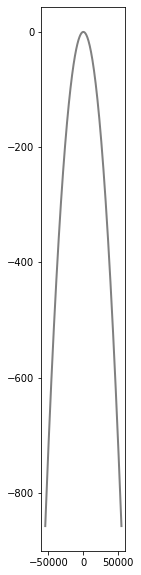

In [14]:
# plot path cartesian
dpi = 72

#fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10),dpi=dpi)

# Create 2x2 sub plots
gs = gridspec.GridSpec(ncols=3, nrows=1,width_ratios=[1,20,2.5])

pl.figure(figsize=(40,10))


# left
ax = pl.subplot(gs[0, 0]) # row 0, col 0

offset_y = r_moon
# moon surface
t = np.linspace(0.49*np.pi,0.51*np.pi,1000)
pl.plot(r_moon*np.cos(t), r_moon*np.sin(t)-offset_y,color='grey', linewidth=2)

xpoints = df.loc[0.0:phase3_end+2]['pos_x [m]']
ypoints = df.loc[0.0:phase3_end+2]['pos_y [m]']

max_x = np.max(xpoints)
max_y = np.max(ypoints-offset_y)
min_x = np.min(xpoints)
min_y = np.min(ypoints-offset_y)

pad_y = 1e1
pad_x = 1e2

ax.set_xlim(min_x-pad_x, max_x)
ax.set_ylim(min_y-pad_y, max_y+pad_y)

ax.set_aspect('equal', adjustable='box')
ax.grid(True)
pl.plot(xpoints[:round(phase1_end+1)],ypoints[:round(phase1_end+1)]-offset_y                                  , color='deeppink') # phase 1
pl.plot(xpoints[round(phase1_end):round(phase2_end+1)],ypoints[round(phase1_end):round(phase2_end+1)]-offset_y, color='magenta') # phase 2
pl.plot(xpoints[round(phase2_end):round(phase3_end+1)],ypoints[round(phase2_end):round(phase3_end+1)]-offset_y, color='darkviolet') # phase 3
pl.plot(xpoints[round(phase3_end):],ypoints[round(phase3_end):]-offset_y                        ,color='tab:blue') # phase 4

#middle
ax = pl.subplot(gs[0, 1])

t = np.linspace(0.45*np.pi,0.51*np.pi,1000)
pl.plot(r_moon*np.cos(t), r_moon*np.sin(t)-offset_y,color='grey', linewidth=2)

xpoints = df.loc[phase3_end:phase4_end]['pos_x [m]']
ypoints = df.loc[phase3_end:phase4_end]['pos_y [m]']

max_x = np.max(xpoints)
max_y = np.max(ypoints-offset_y)
min_x = np.min(xpoints)
min_y = np.min(ypoints-offset_y)

pad_y = 1e4
pad_x = 1e3

ax.set_xlim(min_x-pad_x, max_x)
ax.set_ylim(min_y-pad_y, max_y+pad_y)

ax.set_aspect('equal', adjustable='box')
ax.grid(True)
pl.plot(xpoints,ypoints-offset_y,color='tab:blue', linewidth=2) # phase 4

xpoints = df.loc[:phase3_end]['pos_x [m]']
ypoints = df.loc[:phase3_end]['pos_y [m]']

pl.plot(xpoints,ypoints-offset_y, linewidth=2, color='magenta') # until phase 4

# right
ax = pl.subplot(gs[0, 2]) # row 0, col 1
pl.plot([0,1])

# moon surface
t = np.linspace(0,2*np.pi,100)
pl.plot(r_moon*np.cos(t), r_moon*np.sin(t),color='grey', linewidth=2)

xpoints_prop = df.loc[phase4_end:]['pos_x [m]']
ypoints_prop = df.loc[phase4_end:]['pos_y [m]']
pl.plot(xpoints_prop,ypoints_prop, color='tab:green', linewidth=1) # propagate

xpoints = df.loc[0.0:phase4_end]['pos_x [m]']
ypoints = df.loc[0.0:phase4_end]['pos_y [m]']
pl.plot(xpoints,ypoints, linewidth=2 ) # start

ext = np.max(np.abs([ df['pos_x [m]'],df['pos_y [m]']]))

ax.set_ylim(-ext, ext)
ax.set_xlim(-ext, ext)
ax.set_aspect('equal', adjustable='box')
ax.grid(True)

plt.savefig('doc/img/launch_segment.png',bbox_inches='tight',dpi=300)
#plt.axis('off')
plt.show()

# plot result properties graphs

df[['altitude [m]','vel_r [m/s]','vel_phi [m/s]','acc_r [m/s²]','acc_phi [m/s²]','dir_n [°]']].plot(subplots=True,figsize=(25,20),grid=True,xlim=[0, df.index[-1]])
#df.plot(subplots=True,figsize=(20,25))
plt.show()

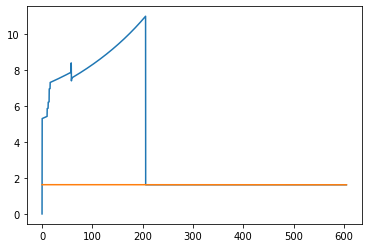

In [383]:
n = len(df['acc_x [m/s²]'].values)
result = np.zeros(n)

acc_x_val = df['acc_x [m/s²]'].values
acc_y_val = df['acc_y [m/s²]'].values

for i in range(n):
    x_vec = acc_x_val[i] * np.array([1,0,0])
    y_vec = acc_y_val[i] * np.array([0,1,0])
    result[i] = norm(x_vec+y_vec)

ypoints = result
xpoints = df.index

plt.plot(xpoints,ypoints)

def acc_grav_moon_2(alt):
    r = alt + r_moon
    r_val = G * (m_moon/(r**2))
    
    return r_val

#verify acc_x acc_y correct

alt = df['altitude [m]'].values
result = np.zeros(n)


for i in range(n):
    result[i]= acc_grav_moon_2(alt[i])
    

ypoints = result
xpoints = df.index

plt.plot(xpoints,ypoints)
plt.show()
# > pass, correct

#verify acc_x acc_y transform > acc_r correct





# STK

In [ ]:
# pip install "C:\Program Files\AGI\STK 12\bin\AgPythonAPI\agi.stk12-12.2.0-py3-none-any.whl"
# run this notebook from STK's Python Scripting Interface

In [ ]:
# STK library imports
from agi.stk12.stkdesktop import STKDesktop
from agi.stk12.stkobjects import *
from agi.stk12.stkutil import *
from agi.stk12.vgt import *
# if using astrogator uncomment the below
# from agi.stk12.stkobjects.astrogator
# if using aviator uncomment the below
# from agi.stk12.stkobjects.aviator

# Python helper library imports
import os
from tqdm.notebook import tqdm
from ipywidgets import *
import time
import numpy as np
import plotly.express as px
import xarray as xr

In [ ]:
# helper functions

# model for launch segment

# plot xArray data

## Destination: Gateway (Near-Rectilinear Halo Orbit)
> open file "Gateway_PROP_Mass_Point.sc" in STK

### connect to STK session and grab elements

In [ ]:
# Get reference to the current instance of STK
STK_PID = os.getenv('STK_PID')
stk = STKDesktop.AttachToApplication(pid=int(STK_PID))
root = stk.Root

# rewind to initial datetime
scenario = root.CurrentScenario
scenario.SetTimePeriod('01 Jan 2022 00:00:00.000','03 Jan 2022 00:00:00.000')
root.Rewind()

# load existing Satellite and Place
satellite = root.CurrentScenario.Children.Item('NRHO_Sat')
place_start = root.CurrentScenario.Children.Item('Start')
place_start.Position.AssignGeodetic(0,0,0)

In [ ]:
#satellite  = AgSatellite(root.CurrentScenario.Children.New(AgESTKObjectType.eSatellite,"LeoSat"))
#place_start  = AgPlace(scenario.Children.New(AgESTKObjectType.ePlace,"Start"))

In [ ]:
#def analyse(object):
#    print([method_name for method_name in dir(object)if callable(getattr(object, method_name))])
#print(satellite.Propagator.__dict__.keys())

# use dir() instead

In [ ]:
#analyse(satellite.Propagator.MainSequence.Item(0).Profiles.Item(0).Results.Item(0))
#analyse(satellite.Propagator.MainSequence.Item(0).Profiles.Item(0).ControlParameters.Item(0))
#dir(satellite.Propagator.MainSequence.Item(0).Profiles.Item(0).ControlParameters.Item(0))
# Name
# FinalValue
# LastUpdate
#dir(satellite.Propagator.MainSequence.Item(0).Profiles.Item(0).Results.Item(0))
# Name
# CurrentValue
# DesiredValue
# Difference
# Values


# pull data
#print(satellite.Propagator.MainSequence.Item(2).GetResultValue('Eccentricity'))

#satellite.Propagator.MainSequence.Item(0).Profiles.Item(0).ControlParameters.Item(0).FinalValue
#satellite.Propagator.MainSequence.Item(0).Profiles.Item(0).Results.Item(0).Name

# set data
#satellite.Propagator.MainSequence.Item(0).Segments.Item(0).BurnoutVelocity._SetFixedVelocity(1)
#satellite.Propagator.MainSequence.Item(0).Segments.Item(0).DisplaySystem.Latitude = 44
#satellite.Propagator.MainSequence.Item(0).Segments.Item(0).Burnout.Azimuth = 0

In [ ]:
#airtemps = xr.tutorial.open_dataset('air_temperature').air.isel(time=500)
#airtemps

In [ ]:
#colorbar_title = results.attrs['var_desc'] + '<br>(%s)'%results.attrs['units']
#fig = px.imshow(results, color_continuous_scale='RdBu_r', aspect='equal')
#fig.show()
#fig.write_image("images/fig1.pdf")
#print(satellite.Propagator.MainSequence.Item(0).Profiles.Item(0).ControlParameters.Item(0).FinalValue*1000)
#print()
#print(satellite.Propagator.MainSequence.Item(3).Profiles.Item(0).ControlParameters.Item(0).Name)
#print(satellite.Propagator.MainSequence.Item(3).Profiles.Item(0).ControlParameters.Item(0).FinalValue*1000)
#print(satellite.Propagator.MainSequence.Item(3).Profiles.Item(0).ControlParameters.Item(1).FinalValue*1000)
#print(satellite.Propagator.MainSequence.Item(3).Profiles.Item(0).ControlParameters.Item(2).FinalValue*1000)

#dir(satellite.Propagator.MainSequence.Item(3).Profiles.Item(0).ControlParameters.Item(0))

#print(satellite.Propagator.MainSequence.Item(0).Profiles.Item(0).Status)

#dv2_x = satellite.Propagator.MainSequence.Item(3).Profiles.Item(0).ControlParameters.Item(0).FinalValue*1000
#dv2_y = satellite.Propagator.MainSequence.Item(3).Profiles.Item(0).ControlParameters.Item(1).FinalValue*1000
#dv2_z = satellite.Propagator.MainSequence.Item(3).Profiles.Item(0).ControlParameters.Item(2).FinalValue*1000
#dv2_vec = np.array([dv2_x, dv2_y, dv2_z])
#dv2 = np.linalg.norm(dv2_vec)
#print(dv2)

### control STK and compute global result

In [ ]:
####################################################################################
# WARNING !    this step takes approx. 4 hours to compute for 5 deg resolution     #
####################################################################################

# calculation steps in deg for geodetic location
resolution = 30

print('Result image resolution:',1+(360/resolution),'x',1+(180/resolution))
n_total = (1+(360/resolution))*(1+(180/resolution))
print('number of calculations:',n_total)

if n_total != int(n_total): print("WARNING: non matching map!")

Longitude = []
Latitude = []

for Lon in range(-180,181,resolution):
    Longitude.append(Lon)
for Lat in range(-90,91,resolution):
    Latitude.append(Lat)


Latitude = list(reversed(Latitude))

deltaV_Gateway = np.zeros((len(Latitude), len(Longitude)))
deltaV_Gateway[:] = np.nan

fuel_mass_Gateway = np.zeros((len(Latitude), len(Longitude)))
fuel_mass_Gateway[:] = np.nan

print()
print(len(Longitude),Longitude)
print()
print(len(Latitude),Latitude)

with tqdm(total=n_total) as pbar:
    for Lat_count, Lat in enumerate(Latitude):
        for Lon_count, Lon in enumerate(Longitude):
            #print("Lat:",Lat,"Lon:",Lon)
            place_start.Position.AssignGeodetic(Lat,Lon,0)
            satellite.Propagator.MainSequence.Item(0).Segments.Item(0).DisplaySystem.Latitude = Lat
            satellite.Propagator.MainSequence.Item(0).Segments.Item(0).DisplaySystem.Longitude = Lon
            if Lon > -90 and Lon < 90:
                satellite.Propagator.MainSequence.Item(0).Segments.Item(0).Burnout.Azimuth = -180
            else:
                satellite.Propagator.MainSequence.Item(0).Segments.Item(0).Burnout.Azimuth = 0
                
            satellite.Propagator.RunMCS()
            check1 = satellite.Propagator.MainSequence.Item(0).Profiles.Item(0).Status
            check2 = satellite.Propagator.MainSequence.Item(3).Profiles.Item(0).Status
            if check1 == "Converged" and check2 == "Converged":
                
                # Launch: Burnout.FixedVelocity
                dv1 = satellite.Propagator.MainSequence.Item(0).Profiles.Item(0).ControlParameters.Item(0).FinalValue*1000
                # Maneuver: ImpulsiveMnvr.Pointing.Cartesian.X /Y /Z
                dv2_x = satellite.Propagator.MainSequence.Item(3).Profiles.Item(0).ControlParameters.Item(0).FinalValue*1000
                dv2_y = satellite.Propagator.MainSequence.Item(3).Profiles.Item(0).ControlParameters.Item(1).FinalValue*1000
                dv2_z = satellite.Propagator.MainSequence.Item(3).Profiles.Item(0).ControlParameters.Item(2).FinalValue*1000
                dv2_vec = np.array([dv2_x, dv2_y, dv2_z])
                dv2 = np.linalg.norm(dv2_vec)

                deltaV_Gateway[Lat_count][Lon_count] = dv2
                fuel_mass_Gateway[Lat_count][Lon_count] = 0
                
            else:
                print("ERROR","did NOT Converge for","Lat:",Lat,"Lon:",Lon)
                
            pbar.update(1)

### save result in xArray

In [ ]:
xA_fuel_mass_Gateway = xr.DataArray(
    data=fuel_mass_Gateway,
    dims=["lat","lon"],
    coords=dict(
        lon=(["lon"], Longitude),
        lat=(["lat"], Latitude)
    ),
    attrs=dict(
        description="DeltaV to Gateway",
        var_desc="deltaV",
        units="m/s",
    ),
)

xA_fuel_mass_Gateway.to_netcdf("maps/fuel_mass_Gateway.nc")

In [ ]:
# load array
xA_fuel_mass_Gateway = xr.open_dataarray("maps/fuel_mass_Gateway.nc")

In [ ]:
colorbar_title = xA_fuel_mass_Gateway.attrs['var_desc'] + '<br>(%s)'%xA_fuel_mass_Gateway.attrs['units']

#fig = px.imshow(results, color_continuous_scale='RdBu_r', aspect='equal')
fig = px.imshow(img=xA_fuel_mass_Gateway,
                width=1000,
                height=500,
                color_continuous_scale='blugrn_r',
                aspect='equal')

fig.update_xaxes(tickangle=0,
                 tickmode = 'array',
                 tickvals = [-180, -150, -120, -90, -60, -30, 0, 30, 60, 90, 120, 150, 180])
fig.update_yaxes(tickangle=0,
                 tickmode = 'array',
                 tickvals = [-90,-60,-30,0,30,60,90])


fig.update_layout(
    xaxis_title='Longitude',
    yaxis_title='Latitude',
    title= 'DeltaV Map<br>Destination Gateway',
    title_x=0.45
)


#fig.write_image("fig/dv1.pdf")
fig.write_image("doc/img/dv_Gateway.pdf")
fig.show()


In [ ]:
#print(scenario.StartTime)
#print(scenario.StopTime)

In [ ]:
root.ExecuteCommand('SetState */Satellite/LeoSat Classical TwoBody "' +
                    str(scenario.StartTime) + '" "' + str(scenario.StopTime) +
                    '" 60 ICRF  "' + str(scenario.StartTime) + '" 7200000.0 0.0 90 0.0 0.0 0.0')

In [ ]:
access = satellite.GetAccessToObject(target)
access.ComputeAccess()

In [ ]:
accessDP         = access.DataProviders.Item('Access Data')

results          = accessDP.Exec(scenario.StartTime, scenario.StopTime)

accessStartTimes = results.DataSets.GetDataSetByName('Start Time').GetValues()

accessStopTimes  = results.DataSets.GetDataSetByName('Stop Time').GetValues()

print(accessStartTimes,accessStopTimes)

In [ ]:
accessIntervals = access.ComputedAccessIntervalTimes

dataProviderElements = ['Start Time', 'Stop Time']

for i in range(0,accessIntervals.Count):
    times = accessIntervals.GetInterval(i)
    print(times)

### Retrieve the Satellite Altitude Data From STK

Retrieve and view the altitude of the satellite during an access interval. In the following lines, note how the data providers must follow the data provider folder, sub-folder, and selection.

In [ ]:
satelliteDP       = satellite.DataProviders.Item('LLA State')

satelliteDP2      = satelliteDP.Group.Item('Fixed')

rptElements       = ['Time', 'Lat', 'Lon', 'Alt']

satelliteDPTimeVar = satelliteDP2.ExecElements(accessStartTimes,accessStopTimes, 60, rptElements)

satelliteAltitude = satelliteDPTimeVar.DataSets.GetDataSetByName('Alt').GetValues()

print(satelliteAltitude)

## Destination: Low Lunar Orbit (Equatorial)
> open file "Gateway_PROP_Mass_Point.sc" in STK

In [ ]:
# Get reference to the current instance of STK
STK_PID = os.getenv('STK_PID')
stk = STKDesktop.AttachToApplication(pid=int(STK_PID))
root = stk.Root

# rewind to initial datetime
scenario = root.CurrentScenario
scenario.SetTimePeriod('01 Jan 2022 00:00:00.000','03 Jan 2022 00:00:00.000')
root.Rewind()

# load existing Satellite and Place
satellite = root.CurrentScenario.Children.Item('LLO_Sat_Eq')
place_start = root.CurrentScenario.Children.Item('Start')
place_start.Position.AssignGeodetic(0,0,0)

## Destination: Low Lunar Orbit (Polar)
> open file "Gateway_PROP_Mass_Point.sc" in STK

In [ ]:
# Get reference to the current instance of STK
STK_PID = os.getenv('STK_PID')
stk = STKDesktop.AttachToApplication(pid=int(STK_PID))
root = stk.Root

# rewind to initial datetime
scenario = root.CurrentScenario
scenario.SetTimePeriod('01 Jan 2022 00:00:00.000','03 Jan 2022 00:00:00.000')
root.Rewind()

# load existing Satellite and Place
satellite = root.CurrentScenario.Children.Item('LLO_Sat_Pol')
place_start = root.CurrentScenario.Children.Item('Start')
place_start.Position.AssignGeodetic(0,0,0)

## Destination: Lagrange Point (L1) - Earth Moon System
> open file "Gateway_PROP_Mass_Point.sc" in STK

## Destination: Low Earth Orbit (Equatorial) - Starship refuel
> open file "Gateway_PROP_Mass_Point.sc" in STK